In [41]:
from pathlib import Path

import numpy as np
import torch
%matplotlib inline
import matplotlib.pyplot as plt

from super_segmenter.models import UNet
from super_segmenter.utils.params import Registry
from super_segmenter.training.data import PascalPartDataset

In [52]:
PARAMS_SET = "u_net_baseline"
MODEL_PATH = Path("/home/lyy92/data/models/unet/checkpoint-7413")
params = Registry.get_params(PARAMS_SET)

In [53]:
valid_dataset = PascalPartDataset(
    ids_path=params.data_params.val_ids_path,
    images_dir_path=params.data_params.images_dir_path,
    masks_dir_path=params.data_params.gt_masks_dir_path,
    img_size=params.data_params.image_size
)

In [54]:
model = UNet(num_classes=params.model_params.num_classes).to("cpu")
model.load_state_dict(
    torch.load(MODEL_PATH, map_location=torch.device("cpu"))
)
model.eval()

UNet(
  (contracting_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contr

In [57]:
def infer(image: torch.Tensor, transform=None) -> torch.Tensor:
   if transform:
      image = transform(image)
   
   probs = torch.softmax(model(image.unsqueeze(dim=0)), dim=1)
   return torch.argmax(probs, dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


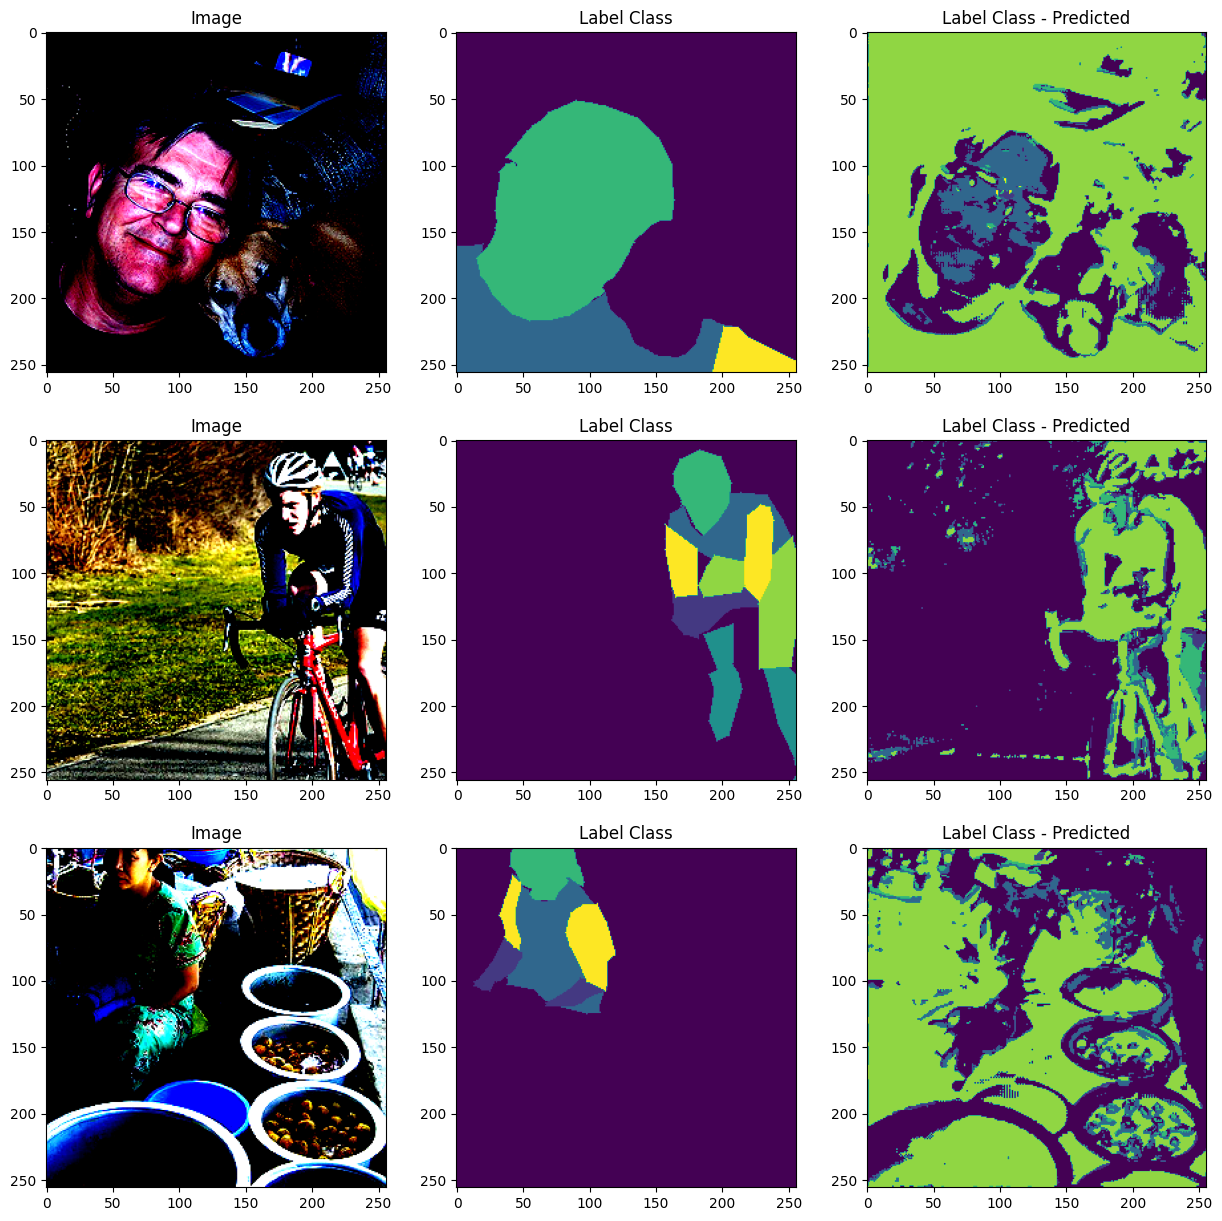

In [56]:
num_vals = 3
fig, axes = plt.subplots(num_vals, 3, figsize=(3*5, num_vals*5))

for i in range(num_vals):
    x_val, y_val = valid_dataset[np.random.randint(len(valid_dataset))]
    out = infer(image=x_val)
    
    image = x_val.permute(1, 2, 0).cpu().detach().numpy()
    label_class = y_val.cpu().detach().numpy()
    label_class_predicted = infer(image=x_val).squeeze().cpu().detach().numpy()
    
    axes[i, 0].imshow(image)
    axes[i, 0].set_title("Image")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")